In [18]:
# import py7zr
# from pathlib import Path

# # extract compressed data file
# data_path = Path('data')
# with py7zr.SevenZipFile(data_path.joinpath('data_dirty.7z'), mode='r') as z:
#     z.extractall(data_path)

In [1]:
import io
import re
import string
import tqdm

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers

In [2]:
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE

In [3]:
from pyfaidx import Fasta
data = Fasta("data/15400-16555_sequence.fasta")

In [9]:
len(data.keys())

1732

In [7]:
count=0
for record in data:
    count+=1
count

1732

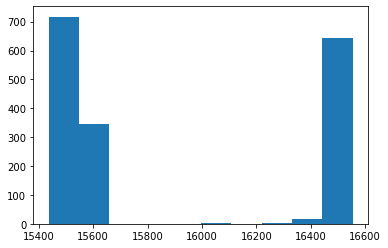

1732
15893.848729792147
512.1947490467297


In [23]:
import matplotlib.pyplot as plt
num_seq = len(data.keys())
seq_len = np.array([len(x[:].seq) for x in data])
plt.hist(seq_len)
plt.show()

print(num_seq)
print(np.mean(seq_len))
print(np.std(seq_len))

In [24]:
def build_kmers(sequence, ksize):
    kmers = []
    n_kmers = len(sequence) - ksize + 1

    for i in range(n_kmers):
        kmer = sequence[i:i + ksize]
        kmers.append(kmer)

    return kmers

In [25]:
ksize = 11
corpus = pd.DataFrame([build_kmers(x[:].seq, ksize) for x in data])
corpus = corpus.fillna(np.NaN)
corpus = corpus.iloc[:3,:]
corpus
# tokens

,0,1,2,3,4,5,6,7,8,9,...,16535,16536,16537,16538,16539,16540,16541,16542,16543,16544
0,TTAACCACTCA,TAACCACTCAC,AACCACTCACG,ACCACTCACGG,CCACTCACGGG,CACTCACGGGA,ACTCACGGGAG,CTCACGGGAGC,TCACGGGAGCT,CACGGGAGCTC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CACCCTATTAA,ACCCTATTAAC,CCCTATTAACC,CCTATTAACCA,CTATTAACCAC,TATTAACCACT,ATTAACCACTC,TTAACCACTCA,TAACCACTCAC,AACCACTCACG,...,TTAAATAAGAC,TAAATAAGACA,AAATAAGACAT,AATAAGACATC,NaN,NaN,NaN,NaN,NaN,NaN
2,TCACAGGTCTA,CACAGGTCTAT,ACAGGTCTATC,CAGGTCTATCA,AGGTCTATCAC,GGTCTATCACC,GTCTATCACCC,TCTATCACCCT,CTATCACCCTA,TATCACCCTAT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
vocab, index = {}, 1  # start indexing from 1
vocab['<pad>'] = 0  # add a padding token
for _, sentence in corpus.iterrows():
  for token in sentence.values:
    if token not in vocab:
      vocab[token] = index
      index += 1
vocab_size = len(vocab)
vocab_size

17191

In [27]:
inverse_vocab = {index: token for token, index in vocab.items()}

In [28]:
example_sequence = [[vocab[word] for word in corpus.iloc[sent,:]] for sent in range(corpus.shape[0])]

In [ ]:
# Get target and context words for one positive skip-gram.
target_word, context_word = positive_skip_grams[0]

# Set the number of negative samples per positive context.
num_ns = 4

context_class = tf.reshape(tf.constant(context_word, dtype="int64"), (1, 1))
negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
    true_classes=context_class,  # class that should be sampled as 'positive'
    num_true=1,  # each positive skip-gram has 1 positive context class
    num_sampled=num_ns,  # number of negative context words to sample
    unique=True,  # all the negative samples should be unique
    range_max=vocab_size,  # pick index of the samples from [0, vocab_size]
    seed=SEED,  # seed for reproducibility
    name="negative_sampling"  # name of this operation
)
print(negative_sampling_candidates)
print([inverse_vocab[index.numpy()] for index in negative_sampling_candidates])

In [30]:
# Generates skip-gram pairs with negative sampling for a list of sequences
# (int-encoded sentences) based on window size, number of negative samples
# and vocabulary size.
def generate_training_data(sequences, window_size, num_ns, vocab_size, seed):
  # Elements of each training example are appended to these lists.
  targets, contexts, labels = [], [], []

  # Build the sampling table for vocab_size tokens.
  sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size)

  # Iterate over all sequences (sentences) in dataset.
  for sequence in tqdm.tqdm(sequences):

    # Generate positive skip-gram pairs for a sequence (sentence).
    positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
          sequence,
          vocabulary_size=vocab_size,
          sampling_table=sampling_table,
          window_size=window_size,
          negative_samples=0)

    # Iterate over each positive skip-gram pair to produce training examples
    # with positive context word and negative samples.
    for target_word, context_word in positive_skip_grams:
      context_class = tf.expand_dims(
          tf.constant([context_word], dtype="int64"), 1)
      negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
          true_classes=context_class,
          num_true=1,
          num_sampled=num_ns,
          unique=True,
          range_max=vocab_size,
          seed=SEED,
          name="negative_sampling")

      # Build context and label vectors (for one target word)
      negative_sampling_candidates = tf.expand_dims(
          negative_sampling_candidates, 1)

      context = tf.concat([context_class, negative_sampling_candidates], 0)
      label = tf.constant([1] + [0]*num_ns, dtype="int64")

      # Append each element from the training example to global lists.
      targets.append(target_word)
      contexts.append(context)
      labels.append(label)

  return targets, contexts, labels

In [32]:
targets, contexts, labels = generate_training_data(
    sequences=example_sequence,
    window_size=2,
    num_ns=4,
    vocab_size=vocab_size,
    seed=SEED)

targets = np.array(targets)
contexts = np.array(contexts)[:,:,0]
labels = np.array(labels)

print('\n')
print(f"targets.shape: {targets.shape}")
print(f"contexts.shape: {contexts.shape}")
print(f"labels.shape: {labels.shape}")


  0%|          | 0/3 [00:00<?, ?it/s]2021-10-28 23:35:00.072990: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
100%|██████████| 3/3 [00:13<00:00,  4.61s/it]




targets.shape: (155417,)
contexts.shape: (155417, 5)
labels.shape: (155417, 5)


In [33]:
BATCH_SIZE = 1024
BUFFER_SIZE = 10000
dataset = tf.data.Dataset.from_tensor_slices(((targets, contexts), labels))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
print(dataset)

<BatchDataset shapes: (((1024,), (1024, 5)), (1024, 5)), types: ((tf.int64, tf.int64), tf.int64)>


In [38]:
dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)
print(dataset)
num_ns = 4


<PrefetchDataset shapes: (((1024,), (1024, 5)), (1024, 5)), types: ((tf.int64, tf.int64), tf.int64)>


In [39]:
class Word2Vec(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim):
    super(Word2Vec, self).__init__()
    self.target_embedding = layers.Embedding(vocab_size,
                                      embedding_dim,
                                      input_length=1,
                                      name="w2v_embedding")
    self.context_embedding = layers.Embedding(vocab_size,
                                       embedding_dim,
                                       input_length=num_ns+1)

  def call(self, pair):
    target, context = pair
    # target: (batch, dummy?)  # The dummy axis doesn't exist in TF2.7+
    # context: (batch, context)
    if len(target.shape) == 2:
      target = tf.squeeze(target, axis=1)
    # target: (batch,)
    word_emb = self.target_embedding(target)
    # word_emb: (batch, embed)
    context_emb = self.context_embedding(context)
    # context_emb: (batch, context, embed)
    dots = tf.einsum('be,bce->bc', word_emb, context_emb)
    # dots: (batch, context)
    return dots

In [40]:
embedding_dim = 128
word2vec = Word2Vec(vocab_size, embedding_dim)
word2vec.compile(optimizer='adam',
                 loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                 metrics=['accuracy'])

In [42]:
word2vec.fit(dataset, epochs=20)

Epoch 1/20
  2/151 [..............................] - ETA: 7s - loss: 1.6093 - accuracy: 0.2056  

2021-10-28 23:37:18.064562: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-10-28 23:37:18.164210: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-28 23:37:18.164256: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-28 23:37:18.206684: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-28 23:37:18.215303: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-28 23:37:18.230955: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/train/plugins/profile/2021_10_28_23_37_18

2021-10-28 23:37:18.247566: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2021_10_28_23_37_18/tinkercliffs1.trace.json.gz
2021-10-28 23:37:18.252677:

  5/151 [..............................] - ETA: 9s - loss: 1.6095 - accuracy: 0.1998 

2021-10-28 23:37:18.287346: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: logs/train/plugins/profile/2021_10_28_23_37_18
Dumped tool data for xplane.pb to logs/train/plugins/profile/2021_10_28_23_37_18/tinkercliffs1.xplane.pb
Dumped tool data for overview_page.pb to logs/train/plugins/profile/2021_10_28_23_37_18/tinkercliffs1.overview_page.pb
Dumped tool data for input_pipeline.pb to logs/train/plugins/profile/2021_10_28_23_37_18/tinkercliffs1.input_pipeline.pb
Dumped tool data for tensorflow_stats.pb to logs/train/plugins/profile/2021_10_28_23_37_18/tinkercliffs1.tensorflow_stats.pb
Dumped tool data for kernel_stats.pb to logs/train/plugins/profile/2021_10_28_23_37_18/tinkercliffs1.kernel_stats.pb



151/151 [==============================] - 10s 66ms/step - loss: 1.5889 - accuracy: 0.6192
Epoch 2/20
151/151 [==============================] - 11s 71ms/step - loss: 1.3079 - accuracy: 0.9855
Epoch 3/20
151/151 [==============================] - 11s 72ms/step - loss: 0.7145 - accuracy: 0.9467
Epoch 4/20
151/151 [==============================] - 11s 73ms/step - loss: 0.4337 - accuracy: 0.9402
Epoch 5/20
151/151 [==============================] - 10s 67ms/step - loss: 0.3060 - accuracy: 0.9601
Epoch 6/20
151/151 [==============================] - 10s 66ms/step - loss: 0.2221 - accuracy: 0.9790
Epoch 7/20
151/151 [==============================] - 10s 66ms/step - loss: 0.1613 - accuracy: 0.9906
Epoch 8/20
151/151 [==============================] - 10s 64ms/step - loss: 0.1171 - accuracy: 0.9964
Epoch 9/20
151/151 [==============================] - 10s 65ms/step - loss: 0.0856 - accuracy: 0.9990
Epoch 10/20
151/151 [==============================] - 10s 68ms/step - loss: 0.0632 - accurac

<PrefetchDataset shapes: (((1024,), (1024, 5)), (1024, 5)), types: ((tf.int64, tf.int64), tf.int64)>

In [47]:
weights = word2vec.get_layer('w2v_embedding').get_weights()[0]
# vocab = vectorize_layer.get_vocabulary()

In [49]:
weights.shape

(17191, 128)

In [51]:
len(vocab)

17191

In [58]:
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  if word is np.NaN:
    continue
  vec = weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()